# Team Viviane Solomon and Brandon Bonifacio
# How We Split Up The Work: We worked together on all parts up to the last part (improving the accuracy), at which point we split up and Vivianne worked on Data Augmentation techniques using the Pytorch Library, such as ColorJittering, Flipping, and rotating and Brandon worked on Dropout, L2, Freezing layers, increasing the size of the FC layer, and momentum.

# HW6: Life Cycle of ML Model

Your goal is to develop a CNN model that, given a cell phone image
taken somewhere inside a building on HMC campus, can identify which building is being
photographed. You may use any online resources that you find helpful, but you must cite your
sources and indicate clearly what portions of your code have been copied and modified from
elsewhere. You may work individually or with a partner on this assignment. Please submit your
assignment as a single jupyter notebook on Sakai. If you work with a partner, make sure to
indicate both partners’ names clearly at the very top of your notebook.

## Part 1: Data Collection/Preparation

In the first part of the assignment, you will do the following:


• Data Collection (15 points). Each student/team will collect 50 cell phone pictures taken
of random locations inside a single building on campus. Please sign up for a building to
photograph in this spreadsheet, and upload your pictures to this shared google drive.
Since the data will be used by the entire class, please complete this portion of the
assignment by Saturday 1pm (-5 points if not done by then). If there are more than 5
buildings represented in the class data, you may simply select 5 buildings to use for this
assignment.


• Data Preparation (15 points). Download the class data onto your laptop. Prepare the
data for use in PyTorch by ensuring image format compatibility, putting the images in a
suitable directory structure, and creating train & validation partitions. Describe your
data preparation process in your notebook.

In [1]:
#Import Statements
import numpy as np
import math
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

### In the cells below, we prepare the data for use in PyTorch by ensuring image format compatiblity, putting the images in a suitable directory structure, and creating train & validation partitions. We describe our data preparation process in the markdown cell below, and then encode it after that. 

### Our data preparation process is as follows. We first resize each image to 256 x 256 pixels to make all images compatible with the input of the ResNet model. Although ResNet will automatically resize different sized images, we felt it was better if we did it ourselves just for consistency's sake. We also convert each image into a Tensor so that we can use it with the super useful Dataloader object. 

### We used a train/val split of 0.3 because we wanted most of the data to be used for training, but we also wanted a large validation set so that the validation loss curve was not noisy. 

In [2]:
def prepare_and_get_loaders():
    """
    This function loads and partitions our image data.
    """
    validation_split = 0.3
    batch_size = 32
    num_workers = 8
    
    dir_path = "Cropped_Data_4000" #Local path to our images in the directory
    
    
    #help(transforms.Compose)
    
    #Here is the code that has all of the fun transformations we could ever want:
    #https://github.com/pytorch/vision/blob/main/torchvision/transforms/transforms.py
    #And official documentation: https://pytorch.org/vision/stable/transforms.html
    #Helpful Video: https://www.youtube.com/watch?v=ovZ_54IUSU4
    #https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
    transform = transforms.Compose([
        transforms.Resize((244, 244)),
        transforms.ToTensor()
    ])
    #help(transform)
    
    full_dataset = datasets.ImageFolder(dir_path, transform=transform) #This gets our full_dataset
    #help(full_dataset) 

    m = len(full_dataset)
    val_size = int(validation_split * m)
    train_size = m - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers = num_workers)
    #help(train_loader)
    
    return train_loader, val_loader


In [3]:
def get_imgs(loader):
    #This is a function if we just want an easy list of the images, won't be used, but 
    #is archaic code from beginning of it
    X, Y = [], []
    
    for images, labels in tqdm(loader):
        # Convert tensors to numpy arrays and then append to lists
        for i in range(len(images)):
            X.append(images[i].numpy())
            Y.append(labels[i].item())
    return X, Y


# Below, we included a show_images function to show you the images after we load them and what they look like. 

In [4]:
#code for showing example images
def show_images(loader):
    #Show some example images from a loader
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 8)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))

100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:43<00:00,  1.18s/it]


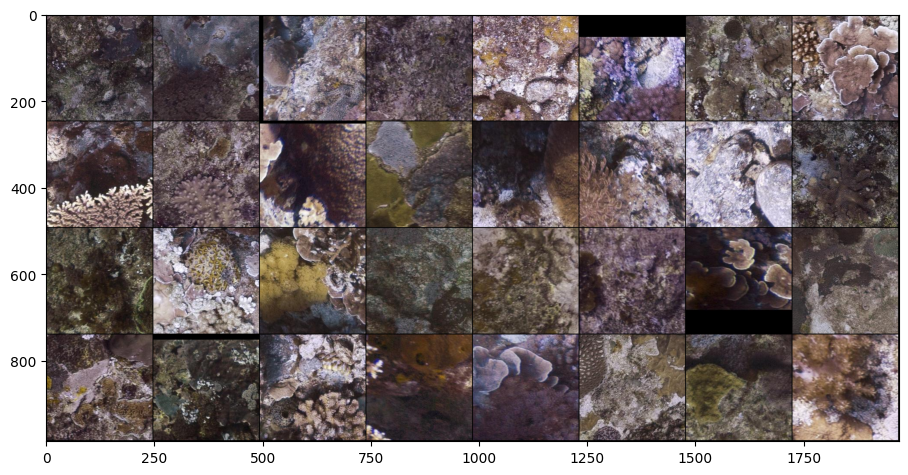

In [5]:
train_loader, val_loader = prepare_and_get_loaders()
X_train, Y_train = get_imgs(train_loader)
X_val, Y_val = get_imgs(val_loader)
show_images(train_loader)

# Summary of Part 1: 
## We successfully uploaded our images to the google drive before Saturday at 1 pm, and we followed the instructions given to us. We also successfully loaded the images in with PyTorch, put the images in the proper directory structure, processed the images, and put them in a train and validation set. 

## Part 2: Nearest Neighbors Approach

In the second part of the assignment, you will do the following:

• Feature extraction (15 points). Find a pretrained CNN model (e.g. ResNet) and use the
penultimate layer activations as a feature representation. Your jupyter notebook should
include code that demonstrates how to use the pretrained model to extract features
from an image in the dataset.


• Nearest Neighbor Method (15 points). Extract features from all the images in the
training set and store them in a single file along with the building labels. For each image
in the validation set, use the pretrained CNN model to extract the feature
representation, calculate which training image is closest in Euclidean distance, and use
its label as the prediction. Report your classification accuracy.

# In this part, we loaded a Resnet18 model and then put the model in eval mode so that it wouldn't train. Then, we extracted the features from it to use in the nearest neighbor algorithm. Using this, we obtained an accuracy of 70%. 

In [6]:
def load_resnet():
    """
    
    Loads a pretrained ResNet model. 
    
    """
    
    #Useful Resource: https://stackoverflow.com/questions/52548174/how-to-remove-the-last-fc-layer-from-a-resnet-model-in-pytorch
    model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
    
    #we gotta keep all layers except the last one
    modules = list(model.children())[:-1] 
    model = nn.Sequential(*modules)
    model.eval()
    
    return model

In [7]:
def feature_extraction(model, loader):
    """
    
    Uses a pretrained model and returns the penultimate layer activations 
    as a feature representation. 
    
    This code demonstrates how to use a pretrained model to extract features from an image in the dataset
    
    """
    features_list = []
    labels_list = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    with torch.no_grad(): #No Training
        for inputs, labels in tqdm(loader, desc="Extracting: "):
            inputs.to(device)
            feature = model(inputs) 
            feature.flatten(start_dim=1)
            features_list.append(feature)
            labels_list.append(labels)
    
    #put the features all togehter
    features = torch.cat(features_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    
    return features, labels

In [8]:
def nearest_neighbors(X_train_features, Y_train, data_features):
    """
    
    Here, we calculate which training image is closest in Euclidean distance to each given validation image,
    and we use that to label the training image. 
    
    """
    
    labels = []
    for feature in data_features:
        distances = torch.sqrt(torch.sum((X_train_features - feature)**2, dim=1))
        index = torch.argmin(distances).item()
        labels.append(int(Y_train[index]))

    return np.array(labels)

In [9]:
model = load_resnet()
train_loader, val_loader = prepare_and_get_loaders()
X_train_features, Y_train = feature_extraction(model, train_loader)
X_val_features, Y_val = feature_extraction(model, val_loader)
val_labels = nearest_neighbors(X_train_features, Y_train, X_val_features)

Y_val = np.array(Y_val)
accuracy = 100 * np.mean(val_labels==Y_val)
print(f"Our classification accuracy using a nearest-single-neighbor approach is {accuracy:.2f}%")

Extracting: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

Our classification accuracy using a nearest-single-neighbor approach is 70.27%


# Thus, as we showed here, we successfully implemented the nearest neighbors algorith and achieved a classification accuracy of 70%. 

## Part 3: Fine-tuning Approach

In the third part of the assignment, you will do the following:


• Finetuning (25 points). Remove the output layer of the pretrained CNN model and
replace it with a randomly initialized output layer that classifies among the 5 buildings of
interest. Finetune the modified model on the training samples. Include your
training/validation loss curves in your notebook, along with the final validation
classification accuracy.


• Improvements (10 points). Experiment with different ways to improve the validation
accuracy. Include any results or figures to document your progress.


# In this section, we removed the output layer of a pretrained CNN model and then replaced it with a FC layer with 5 outputs. Then, we trained this ResNet18 model and, without any special data augmentation techniques, obtained a final validation classification accuracy of 73%. We also added Weight_Decay, or L2 Regularization, to prevent overfitting. 

In [6]:
def load_random_resnet():
    """
    
    Loads a pretrained ResNet model, but with the final output layer removed and replaced with a randomly 
    initialized output layer that will classify among the 5 buildings. 
    
    """
    
    model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
    num_ftrs = model.fc.in_features
    
    #Replace the last FC layer so that it'll have 5 classes
    model.fc = nn.Linear(num_ftrs, 4)
    
    return model

In [7]:
def finetune(model, train_loader, val_loader, learning_rate, num_epochs):
    """
    
    Trains the given model on the X_train and Y_train data, and returns the trained model as well as the losses
    and final validation accuracy.
    
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    #https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,  weight_decay=0.01) #me and my homies love Adam
    
    hist = {'train': [], 'val': []} # History of training and validation losses
    
    for epoch in tqdm(range(num_epochs), desc = "Training Epoch: "):
        model.train() #Training mode
        total_loss = 0.0
        for inputs, labels in train_loader:
            #put stuff on device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            #zero optimizer
            optimizer.zero_grad()
            
            #get outputs + train
            outputs = model(inputs)
            
            #get loss and do backward 
            loss = criterion(outputs, labels)
            loss.backward()
            
            #step
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        hist['train'].append(avg_train_loss)
        
        #Validation Mode Now
        model.eval()
        total_loss = 0.0
        
        #keep track of correct labels so we can get the val accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                #put on device
                inputs = inputs.to(device)
                labels = labels.to(device)

                #get outputs
                outputs = model(inputs)
                
                #get loss
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                
                #https://www.digitalocean.com/community/tutorials/pytorch-torch-max
                max_element, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = total_loss / len(val_loader)
        hist['val'].append(avg_val_loss)
        val_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
    #final val accuracy
    final_val_accuracy = 100*correct/total
    
    return model, hist, final_val_accuracy

In [8]:
def plot_history(hist):
    epochs = range(1, len(hist['train']) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, hist['train'], 'b', label='Training loss')
    plt.plot(epochs, hist['val'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [9]:
learning_rate = 0.00002
num_epochs = 5
train_loader, val_loader = prepare_and_get_loaders()
part3_model = load_random_resnet()
model, hist, final_val_accuracy = finetune(part3_model, train_loader, val_loader, learning_rate, num_epochs)
print(f"Our final validation accuracy accuracy using the full CNN is {final_val_accuracy:.2f}%")

Training Epoch:  20%|█████████████▌                                                      | 1/5 [00:29<01:56, 29.01s/it]

Epoch [1/5], Training Loss: 1.3287, Validation Loss: 1.2707, Validation Accuracy: 31.67%


Training Epoch:  40%|███████████████████████████▏                                        | 2/5 [00:57<01:26, 28.68s/it]

Epoch [2/5], Training Loss: 0.9730, Validation Loss: 1.1843, Validation Accuracy: 43.33%


Training Epoch:  60%|████████████████████████████████████████▊                           | 3/5 [01:26<00:57, 28.68s/it]

Epoch [3/5], Training Loss: 0.7518, Validation Loss: 1.1125, Validation Accuracy: 55.83%


Training Epoch:  80%|██████████████████████████████████████████████████████▍             | 4/5 [01:54<00:28, 28.49s/it]

Epoch [4/5], Training Loss: 0.5835, Validation Loss: 1.0757, Validation Accuracy: 56.67%


Training Epoch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.61s/it]

Epoch [5/5], Training Loss: 0.4937, Validation Loss: 1.0284, Validation Accuracy: 57.50%
Our final validation accuracy accuracy using the full CNN is 57.50%


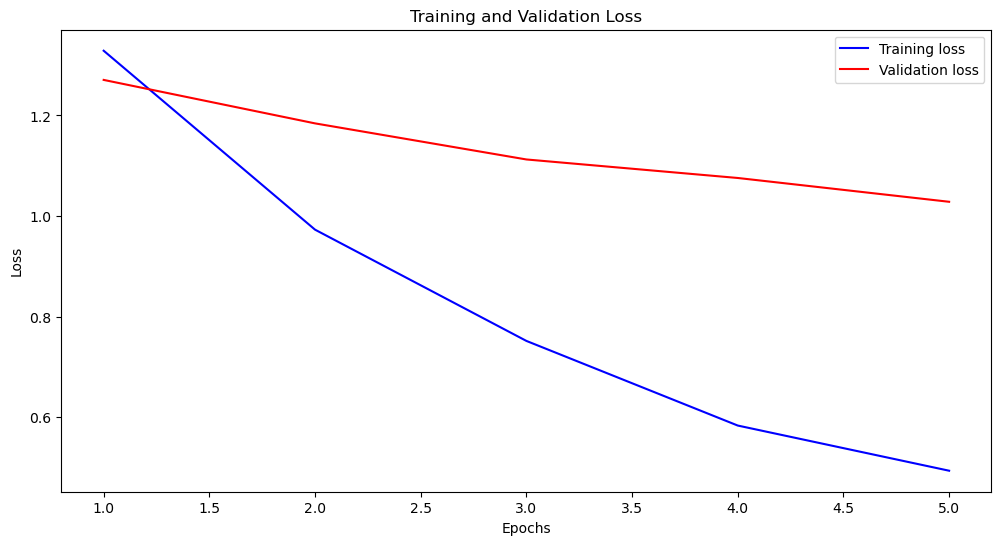

In [10]:
plot_history(hist)

# As a summary of the finetune section, we were able to successfully finetune a ResNet model and then train it (with L2 regularization to help against overfitting) to achieve an accuracy of 66%. We note that we could have continued to train this model to obtain the accuracy, but we will do this in the next section where we try to improve the accuracy as much as possible. It is important to keep the training loss and validation loss as similar as possible to prevent overfitting. 

# In this section, we will experiment with different methods to improve the accuracy of our finetuned model. 


In [14]:
learning_rate = 0.0001
num_epochs = 5
train_loader, val_loader = prepare_and_get_loaders()
part3_model = load_random_resnet()
model, hist, final_val_accuracy = finetune(part3_model, train_loader, val_loader, learning_rate, num_epochs)
print(f"Our final validation accuracy accuracy using the full CNN is {final_val_accuracy:.2f}%")

Training Epoch:  20%|█████████████▌                                                      | 1/5 [00:46<03:07, 46.85s/it]

Epoch [1/5], Training Loss: 1.3642, Validation Loss: 1.1460, Validation Accuracy: 62.16%


Training Epoch:  40%|███████████████████████████▏                                        | 2/5 [01:35<02:23, 47.72s/it]

Epoch [2/5], Training Loss: 0.3609, Validation Loss: 0.9235, Validation Accuracy: 72.97%


Training Epoch:  60%|████████████████████████████████████████▊                           | 3/5 [02:25<01:37, 48.80s/it]

Epoch [3/5], Training Loss: 0.1579, Validation Loss: 0.6752, Validation Accuracy: 74.32%


Training Epoch:  80%|██████████████████████████████████████████████████████▍             | 4/5 [03:13<00:48, 48.42s/it]

Epoch [4/5], Training Loss: 0.0582, Validation Loss: 0.7603, Validation Accuracy: 70.27%


Training Epoch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [04:01<00:00, 48.33s/it]

Epoch [5/5], Training Loss: 0.0309, Validation Loss: 0.7413, Validation Accuracy: 72.97%
Our final validation accuracy accuracy using the full CNN is 72.97%


# As another note, this (code above) was another regular ResNet we finetuned, and although it was overfit, it did get a better validation accuracy of 73%. 

# Below, we delve into the methods we tried in order to improve the accuracy. 

## The first set of experiments we did pertain to data transforms and data augmentation.
### Vivianne's Work

The data transform section below has been included for data augmentation purposes. As we are dealing with a relatively small dataset of images, introducing the augmentation step reduces overfitting by adding consistent, randomized variation – or noise – to the dataset.

The data transforms section below includes transformations for the training dataset and validation dataset, which are distinct. Some examples of transformations include random flipping of the images vertically or horizontally, rotations of the images, or modifications to the brightness, contrast, saturation and hue of the image. They also involve normalizing the images, as well as a resizing to change the pixel resolution.

Adding these augmentation steps can improve the accuracy of the CNN model, as there would be more noise introduced to the training portion of the dataset. The bulk of the data augmentation is done in this training step rather than in the testing step, as one would want to train the model to be as generalized as possible, while not subjecting the testing set to the same difficulties. Some data augmentation such as normalization, resizing,and converting the image to a Tensor occurs within both the training and testing datasets.

During this augmentation approach, we made sure to only modify one variable at a time in an attempt to better understand each transformation's distinct impact on achieving accuracy. Some transformations, such as the normalization step was kept at a specific set of values for the mean and standard deviation, as they are commonly used and empirically tuned for ImageNet



Data augmentation: 

Here are the results we achieved when modifying each individual variable:

-removing normalization: 48%

-with pixel resolution 256: 74%

-with pixel resolution 512 instead of 256: 75.81%

-with pixel resolution 512, removing vertical flip: ~81%

-with pixel resolution 512, removing horizontal flip: ~81%

-with pixel resolution 512, keeping normalization and removing color jitter: 77.42%

-with pixel resolution 512, keeping normalization and removing random rotation 80.65%

-with pixel resolution 512, keeping normalization, without rotations, vertical flip or horizontal flip: 91.94%

Thus, the most favorable data transformations included normalization, converting the images to a Tensor, reshaping the images for a higher pixel resolution, and modifying image features such as hue, saturation, contrast and brightness. The settings for color Jitter (hue,saturation, contrast, brightness)are common practice, with our source included below. Data transformations that were not found to be as favorable included flipping the images vertically and horizontally, and rotating the images. This could be because the images in the dataset were taken with a relatively consistent orientation, and adding that complexity to the training dataset could have made it more difficult than necessary for the testing data to perform as well.

## The second set of experiments we did pertain L2 Normalization, Dropout, Momentum, and other Training Techniques. 

### Brandon's Work

As per the notes given during lecture, the next thing to experiment with after experimenting with the data is the training techniques, namely L2 Normalization, Dropout, and Momentum. Although we tried experimenting with this, in reality we found that high dropout, L2, and Momentum values did not help the training much. Instead, we found it was better to let the model train without these at first, and then introduce them into it gently as the epochs increased. However, because we were able to get up to 95% accuracy without relying on these too much, these played a smaller part. As a note, the default values for momentums in the Adam model are 0.9 and 0.999, so by setting these to 0, we changed the values of the standard Adam model. 

Another thing we tried was freezing the non-FC layers. Although this made the epochs train faster, this did not get very high accuraces, so we opted to train the entire model instead. 

### Below, we show the results of the augmentation approach. By using the methods we explained above, we were able to get a validation accuracy as high as 95.8%. 

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


def prepare_and_get_loaders_augmentation(val_split):
    """
    This function loads and partitions our image data.
    """
    validation_split = val_split #play with this
    batch_size = 32 #play with this
    num_workers = 0 #increasing this number makes it go faster - multiprocessing
    
    dir_path = "Cropped_Data_4000" #path
    
    #Applying different transform to each dataset, helpful resource:
    #https://stackoverflow.com/questions/75010445/pytorch-apply-different-transform-to-dataset-after-creation
    #https://discuss.pytorch.org/t/changing-transformation-applied-to-data-during-training/15671
    #https://albumentations.ai/docs/api_reference/augmentations/transforms/

    data_transforms = {
        'train': transforms.Compose([
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Adjust RGB mean, std!
    ]),

        'test': transforms.Compose([
            transforms.Resize((244,244)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Adjust RGB mean, std!
        ])
    }
    full_dataset = datasets.ImageFolder(dir_path)

    m = len(full_dataset)
    val_size = int(validation_split * m)
    train_size = m - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    train_dataset = MyDataset(train_dataset, transform=data_transforms['train'])
    val_dataset = MyDataset(val_dataset, transform=data_transforms['test'])
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return train_loader, val_loader

In [7]:
def better_finetune(model, train_loader, val_loader, learning_rate, num_epochs, L2, momentum1, momentum2):
    """
    
    Trains the given model on the X_train and Y_train data, and returns the trained model as well as the losses
    and final validation accuracy.
    
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    #https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    
    #New optimizer
    #https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=L2, betas = (momentum1, momentum2))
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1) #every 5 epochs, learning rate gets multiplied by 0.1
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate) #me and my homies love Adam
    #https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    
    hist = {'train': [], 'val': []} # History of training and validation losses
    
    for epoch in tqdm(range(num_epochs), desc = "Training Epoch: "):
        model.train() #Training mode
        total_loss = 0.0
        for inputs, labels in train_loader:
            #put stuff on device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            #zero optimizer
            optimizer.zero_grad()
            
            #get outputs + train
            outputs = model(inputs)
            
            #get loss and do backward 
            loss = criterion(outputs, labels)
            loss.backward()
            
            #step
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        hist['train'].append(avg_train_loss)
        
        #Validation Mode Now
        model.eval()
        total_loss = 0.0
        
        #keep track of correct labels so we can get the val accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                #put on device
                inputs = inputs.to(device)
                labels = labels.to(device)

                #get outputs
                outputs = model(inputs)
                
                #get loss
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                
                #https://www.digitalocean.com/community/tutorials/pytorch-torch-max
                max_element, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = total_loss / len(val_loader)
        hist['val'].append(avg_val_loss)
        val_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
    #final val accuracy
    final_val_accuracy = 100*correct/total
    
    return model, hist, final_val_accuracy

In [8]:
def load_custom_resnet(dropout):
    """
    
    Loads a pretrained ResNet model, but with the final output layer removed and replaced with a randomly 
    initialized output layer that will classify among the 5 buildings. 
    
    """
    
    model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
    num_ftrs = model.fc.in_features
    
    model.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, 5)) #adding dropout
    
    return model

In [ ]:
learning_rate = 0.0001
num_epochs = 3
dropout = 0#0.3#0.05#0.2 #probability something gets dropped
L2 = 0#10**(-2)#10**(-4)#10**(-4)
val_split = 0.1    #0.08 -> 38 validation images... ok ok, -> 475 images...?
momentum1 = 0#0.8
momentum2 = 0#0.8

train_loader, val_loader = prepare_and_get_loaders_augmentation(val_split)
part3_model = load_custom_resnet(dropout)
model, hist, final_val_accuracy = better_finetune(part3_model, train_loader, val_loader, learning_rate, num_epochs, L2, momentum1, momentum2)

print(f"Our final validation accuracy accuracy using the full CNN is {final_val_accuracy:.2f}%")

Training Epoch:   0%|                                                                            | 0/3 [00:00<?, ?it/s]

# As shown in this diagram below, the model underwent overfitting towards the end of its training. 

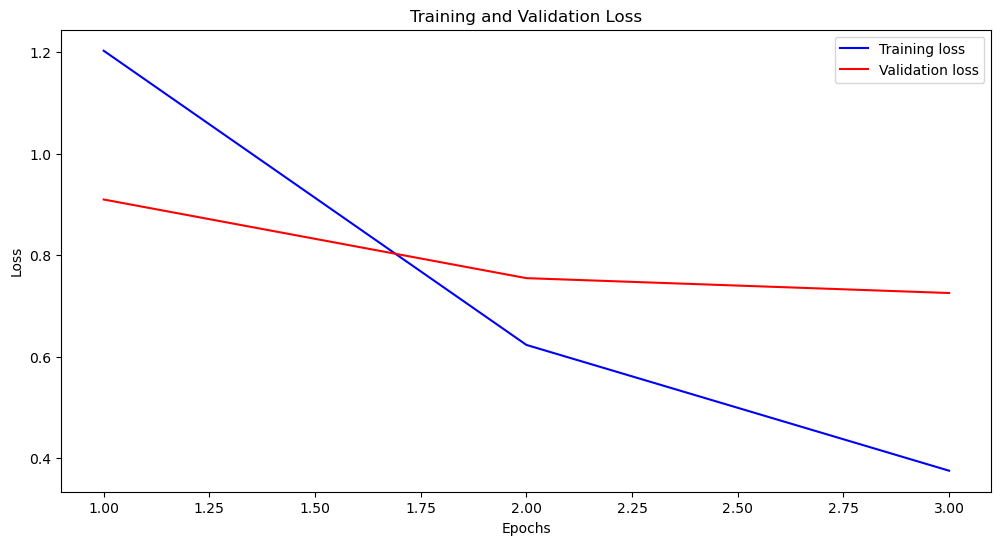

In [20]:
plot_history(hist)

# So, by cutting the model short before it overfits (using the data from our training), we obtain the following model with a maximum validation accuracy of 95.83% without overfitting, and then it went down to 91.67%. However, we also attempted L2, Dropout, and Momentum in the next part to try to fight overfitting🤼‍♂️

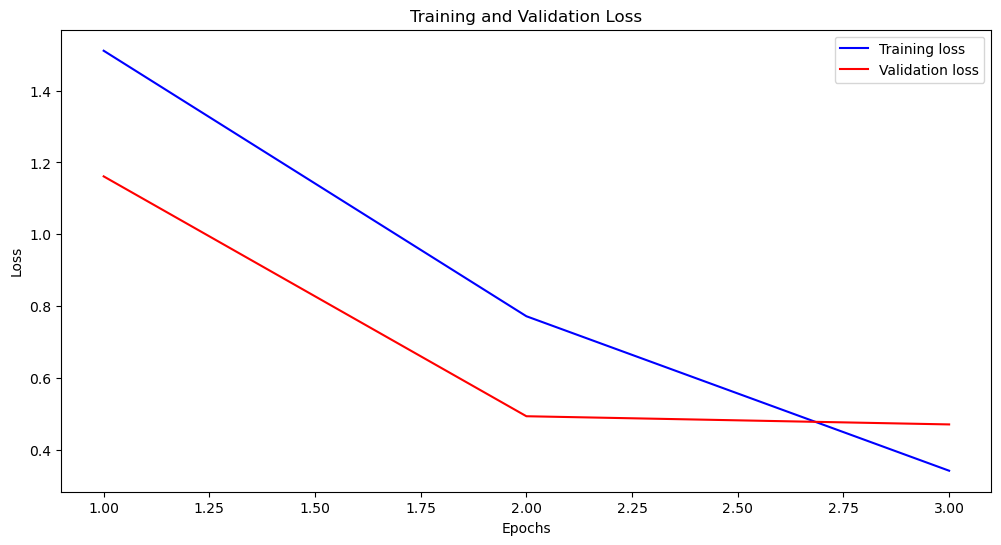

In [105]:
training_loss = [1.5113, 0.7715, 0.3411]
validation_loss = [1.1612, 0.4929, 0.4701]
early_stop_hist = {"train": training_loss, "val": validation_loss}
plot_history(early_stop_hist)

# Below are the results for trying to implement L2, Dropout, Momentum, etc. For this, we achieved a much smoother curve which converged on an accuracy around 92%. 

In [118]:
learning_rate = 0.0001
num_epochs = 3
dropout = 0.3
L2 = 0
val_split = 0.1    
momentum1 = 0
momentum2 = 0

train_loader, val_loader = prepare_and_get_loaders_augmentation(val_split)
part3_model = load_custom_resnet(dropout)
model_dropout, hist, final_val_accuracy = better_finetune(part3_model, train_loader, val_loader, learning_rate, num_epochs, L2, momentum1, momentum2)

print(f"Our final validation accuracy accuracy using the full CNN is {final_val_accuracy:.2f}%")

Training Epoch:  33%|██████████████████████▎                                            | 1/3 [03:20<06:40, 200.44s/it]

Epoch [1/3], Training Loss: 1.7788, Validation Loss: 0.9407, Validation Accuracy: 62.50%


Training Epoch:  67%|████████████████████████████████████████████▋                      | 2/3 [06:44<03:22, 202.62s/it]

Epoch [2/3], Training Loss: 0.8551, Validation Loss: 0.4950, Validation Accuracy: 83.33%


Training Epoch: 100%|███████████████████████████████████████████████████████████████████| 3/3 [10:09<00:00, 203.03s/it]

Epoch [3/3], Training Loss: 0.4991, Validation Loss: 0.5139, Validation Accuracy: 79.17%
Our final validation accuracy accuracy using the full CNN is 79.17%


In [119]:
learning_rate = 0.00001
num_epochs = 1
L2 = 10**(-5)    
momentum1 = 0.9
momentum2 = 0.999

model_dropout, hist, final_val_accuracy = better_finetune(model_dropout, train_loader, val_loader, learning_rate, num_epochs, L2, momentum1, momentum2)

print(f"Our final validation accuracy accuracy using the full CNN is {final_val_accuracy:.2f}%")

Training Epoch: 100%|███████████████████████████████████████████████████████████████████| 1/1 [03:22<00:00, 202.97s/it]

Epoch [1/1], Training Loss: 0.3560, Validation Loss: 0.3298, Validation Accuracy: 83.33%
Our final validation accuracy accuracy using the full CNN is 83.33%


In [120]:
learning_rate = 0.000005
num_epochs = 1
L2 = 10**(-4)    
momentum1 = 0.9
momentum2 = 0.999

model_dropout, hist, final_val_accuracy = better_finetune(model_dropout, train_loader, val_loader, learning_rate, num_epochs, L2, momentum1, momentum2)

print(f"Our final validation accuracy accuracy using the full CNN is {final_val_accuracy:.2f}%")

Training Epoch: 100%|███████████████████████████████████████████████████████████████████| 1/1 [03:22<00:00, 203.00s/it]

Epoch [1/1], Training Loss: 0.2770, Validation Loss: 0.2757, Validation Accuracy: 91.67%
Our final validation accuracy accuracy using the full CNN is 91.67%


In [125]:
final_dropout_accuracy = final_val_accuracy

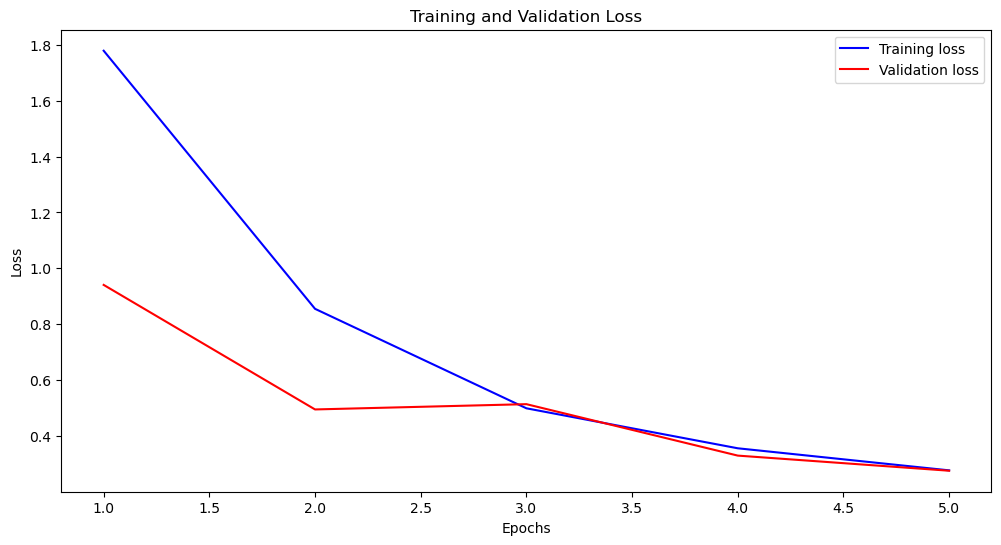

Our Final Validation Accuracy (Also given in the previous cell) is 91.67%


In [126]:
#In this cell, we combine the losses generated by the training outputs to generate our curve. 
dropout_training_loss = [1.7788, 0.8551, 0.4991, 0.3560,  0.2770]
dropout_validation_loss = [0.9407,  0.4950, 0.5139, 0.3298, 0.2757 ]
dropout_hist = {"train": dropout_training_loss, "val": dropout_validation_loss}
plot_history(dropout_hist)

print(f"Our Final Validation Accuracy (Also given in the previous cell) is {final_dropout_accuracy:.2f}%")

# To summarize our work in this part, we first started off with fairly low accuracies in the 70-80 percentages, but after experimenting with data augmentation techniques, we found that ColorJittering allowed us to increase our accuracy to the low 90's and high 80 percentages.


# However, before implementing L2/Dropout/Momentum and just using data augmentation, we were able to achieve a one-time validation accuracy of 96%, but then this accuracy went down due to overfitting. Our main problem with this was overfitting. 

# Then, once L2, Dropout, and Momentum were implemented along with the Data Augmentation techniques, we were able to prevent overfitting and converge the Training and Validation loss curves, with a final validation accuracy at 92%. 

### References / Running list of resources we used:


Resource we used to help us: https://www.kaggle.com/datasets/prasanshasatpathy/soil-types/data

https://stackoverflow.com/questions/58606442/change-the-image-size-and-range

https://www.tensorflow.org/tutorials/load_data/images


Right now, the mean and STD is tuned for imageNet, but it's industry standard and should work for ResNet


Here is the code that has all of the fun transformations we could ever want:

https://github.com/pytorch/vision/blob/main/torchvision/transforms/transforms.py

And official documentation: https://pytorch.org/vision/stable/transforms.html

Helpful Video: https://www.youtube.com/watch?v=ovZ_54IUSU4

https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
    
    
https://stackoverflow.com/questions/52548174/how-to-remove-the-last-fc-layer-from-a-resnet-model-in-pytorch

https://stackoverflow.com/questions/75010445/pytorch-apply-different-transform-to-dataset-after-creation

https://discuss.pytorch.org/t/changing-transformation-applied-to-data-during-training/15671

https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

https://www.digitalocean.com/community/tutorials/pytorch-torch-max

https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear

https://albumentations.ai/docs/api_reference/augmentations/transforms/

As a note, the places of the code where code came from elsewhere have a comment next to them with their source. 